In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# path = '/content/drive/MyDrive/Research/AAAI/dataset2/Arch2/zeroth_layer_with_entropy/k_01/'

In [3]:
!pip install sparsemax

In [4]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from sparsemax import Sparsemax

from matplotlib import pyplot as plt
%matplotlib inline

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

0 530
1 463
2 494
3 517
4 488
5 497
6 493
7 507
8 492
9 519


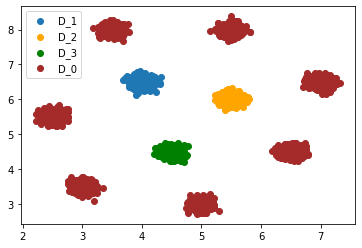

In [6]:
np.random.seed(12)
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)
x = np.zeros((5000,2))
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [4,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [5.5,6],cov=[[0.01,0],[0,0.01]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [4.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [3,3.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [2.5,5.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [3.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [5.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [7,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [6.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [5,3],cov=[[0.01,0],[0,0.01]],size=sum(idx[9]))
color = ['#1F77B4','orange', 'g','brown']
name = [1,2,3,0]
for i in range(10):
  if i==3:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3],label="D_"+str(name[i]))
  elif i>=4:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3])
  else:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[i],label="D_"+str(name[i]))
plt.legend()

In [7]:
desired_num = 6000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,9)
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(a)
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

# load mosaic data

In [8]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label,fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] , self.fore_idx[idx]

In [9]:
batch = 250
msd1 = MosaicDataset(mosaic_list_of_images[0:3000], mosaic_label[0:3000] , fore_idx[0:3000])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [10]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[3000:6000], mosaic_label[3000:6000] , fore_idx[3000:6000])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

# models

In [11]:
class my_spherical_softmax(nn.Module):
    """
    implementation is taken from https://github.com/anirbanl/sparsegen 
    Code for the NeurIPS 2018 paper "On Controllable Sparse Alternatives to Softmax"
    """
    def __init__(self):
        super(my_spherical_softmax,self).__init__()
    def forward(self,x):
        bs = x.data.size()[0]
        dim = x.data.size()[1]
        z = torch.pow(x, 2)
        z_sum = torch.sum(z, dim=1).view(bs, 1).repeat(1, dim)
        return z/z_sum

In [12]:
class Focus_deep(nn.Module):
    '''
       deep focus network averaged at zeroth layer
       input : elemental data
    '''
    def __init__(self,inputs,output,K,d):
        super(Focus_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.K = K
        self.d  = d
        self.linear1 = nn.Linear(self.inputs,50, bias=False)  #,self.output)
        self.linear2 = nn.Linear(50,50 , bias=False)
        self.linear3 = nn.Linear(50,self.output, bias=False) 

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        #self.sparsemax = Sparsemax(dim=-1) 
        self.spherical_softmax = my_spherical_softmax()
        
    def forward(self,z):
        batch = z.shape[0]
        x = torch.zeros([batch,self.K],dtype=torch.float64)
        y = torch.zeros([batch,50], dtype=torch.float64)   # number of features of output
        features = torch.zeros([batch,self.K,50],dtype=torch.float64)
        x,y = x.to(device),y.to(device)
        features = features.to(device)
        for i in range(self.K):
            alp,ftrs = self.helper(z[:,i] )  # self.d*i:self.d*i+self.d
            x[:,i] = alp[:,0]
            features[:,i]  = ftrs 
        #log_x = F.log_softmax(x,dim=1)
        #x = self.sparsemax(x)   # alphas
        #x = F.softmax(x,dim=1)
        x = self.spherical_softmax(x)




        for i in range(self.K):
            x1 = x[:,i]          
            y = y+torch.mul(x1[:,None],features[:,i])  # self.d*i:self.d*i+self.d
        return y , x 
    def helper(self,x):
      #x1 = x
      x = self.linear1(x)
      x = F.relu(x) 
      x = self.linear2(x)
      x1 = F.tanh(x)
      x = F.relu(x)
      x = self.linear3(x)
      #print(x1.shape)
      return x,x1

In [13]:
# class Focus_deep(nn.Module):
#     '''
#        deep focus network averaged at zeroth layer
#        input : elemental data
#     '''
#     def __init__(self,inputs,output,K,d):
#         super(Focus_deep,self).__init__()
#         self.inputs = inputs
#         self.output = output
#         self.K = K
#         self.d  = d
#         self.linear1 = nn.Linear(self.inputs,50, bias=False)  #,self.output)
#         self.linear2 = nn.Linear(50,50 , bias=False)
#         self.linear3 = nn.Linear(50,self.output, bias=False) 

#         torch.nn.init.xavier_normal_(self.linear1.weight)
#         torch.nn.init.xavier_normal_(self.linear2.weight)
#         torch.nn.init.xavier_normal_(self.linear3.weight)
#         #self.sparsemax = Sparsemax(dim=-1) 
#         self.spherical_softmax = my_spherical_softmax()
#     def forward(self,z):
#         batch = z.shape[0]
#         x = torch.zeros([batch,self.K],dtype=torch.float64)
#         y = torch.zeros([batch,self.d], dtype=torch.float64)
#         #x,y = x.to("cuda"),y.to("cuda")
#         #print(z[:,0].shape,z[:,self.d*0:self.d*0+self.d].shape)
#         for i in range(self.K):
#             x[:,i] = self.helper(z[:,i] )[:,0]  # self.d*i:self.d*i+self.d

#         #x = self.sparsemax(x)   # alphas
#         #x = F.softmax(x,dim=1)
#         x = self.spherical_softmax(x)
#         x1 = x[:,0]
#         for i in range(self.K):
#             x1 = x[:,i]          
#             y = y+torch.mul(x1[:,None],z[:,i])  # self.d*i:self.d*i+self.d
#         return y , x   # attended, alpha
#     def helper(self,x):
#       #print(x.shape)
#       x = F.relu(self.linear1(x))
#       x = F.relu(self.linear2(x))
#       x = self.linear3(x)
#       return x


In [14]:
fc = Focus_deep(2,1,9,2).double()
fc = fc.to(device)

In [15]:
fc(torch.randn((2,9,2)).double().to(device))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


(tensor([[-0.0218, -0.0102,  0.0405, -0.2381,  0.5349, -0.1024,  0.0997,  0.3796,
           0.0059,  0.1421, -0.1406, -0.3517, -0.1292, -0.1348, -0.2289,  0.2197,
           0.3191,  0.0167, -0.3927, -0.0705,  0.2939,  0.0417, -0.5260, -0.0736,
          -0.0281, -0.0385,  0.2505,  0.2157, -0.0763,  0.1525, -0.2601,  0.0228,
           0.2705, -0.0454, -0.1650, -0.3315, -0.2112, -0.0416,  0.3064,  0.3057,
           0.0486,  0.1742, -0.3399, -0.2222, -0.0009, -0.3081,  0.1413,  0.1244,
           0.0556, -0.1952],
         [ 0.0553, -0.1043, -0.0432, -0.2089,  0.4787, -0.2111,  0.1799,  0.1767,
          -0.0255,  0.0668, -0.1888, -0.2660, -0.0358,  0.1087, -0.0976,  0.2855,
           0.1975,  0.0326, -0.2786,  0.0715,  0.1452, -0.0594, -0.3330,  0.0928,
          -0.0036,  0.0632,  0.2252,  0.2396, -0.0376, -0.0428, -0.3056,  0.1376,
           0.3755, -0.0221,  0.1033, -0.3057, -0.2023, -0.1296,  0.2063,  0.4155,
           0.0704,  0.2077, -0.2200, -0.2306, -0.0824, -0.1754,  0.02

In [16]:
class Classification_deep(nn.Module):
    '''
       input : elemental data
       deep classification module data averaged at zeroth layer
    '''
    def __init__(self,inputs,output):
        super(Classification_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.linear1 = nn.Linear(self.inputs,50)
        #self.linear2 = nn.Linear(6,12)
        self.linear2 = nn.Linear(50,self.output)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.zeros_(self.linear2.bias)

    def forward(self,x):
      x = F.relu(self.linear1(x))
      #x = F.relu(self.linear2(x))
      x = self.linear2(x)
      return x    

In [17]:
criterion = nn.CrossEntropyLoss()
# def my_cross_entropy(x, y,alpha,log_alpha,k):
#     # log_prob = -1.0 * F.log_softmax(x, 1)
#     # loss = log_prob.gather(1, y.unsqueeze(1))
#     # loss = loss.mean()
#     loss = criterion(x,y)
    
#     #alpha = torch.clamp(alpha,min=1e-10)     
    
#     b = -1.0* alpha * log_alpha
#     b =  torch.mean(torch.sum(b,dim=1))
#     closs = loss
#     entropy = b 
#     loss = (1-k)*loss + ((k)*b)
#     return loss,closs,entropy

In [18]:
def calculate_attn_loss(dataloader,what,where,criter):
  what.eval()
  where.eval()
  r_loss = 0
  alphas = []
  lbls = []
  pred = []
  fidices = []
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels,fidx = data
      lbls.append(labels)
      fidices.append(fidx)
      inputs = inputs.double()
      inputs, labels = inputs.to(device),labels.to(device)



      avg,alpha = where(inputs)
      outputs = what(avg)
      
      
      _, predicted = torch.max(outputs.data, 1)
      pred.append(predicted.cpu().numpy())
      alphas.append(alpha.cpu().numpy())

      loss = criter(outputs,labels)
      r_loss += loss.item()


  alphas = np.concatenate(alphas,axis=0)
  pred = np.concatenate(pred,axis=0)
  lbls = np.concatenate(lbls,axis=0)
  fidices = np.concatenate(fidices,axis=0)

  
  #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
  analysis = analyse_data(alphas,lbls,pred,fidices)
  return r_loss/i,analysis

In [19]:
def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
      focus = np.argmax(alphas[j])
      if(alphas[j][focus] >= 0.5):
        amth +=1
      else:
        alth +=1
      if(focus == f_idx[j] and predicted[j] == lbls[j]):
        ftpt += 1
      elif(focus != f_idx[j] and predicted[j] == lbls[j]):
        ffpt +=1
      elif(focus == f_idx[j] and predicted[j] != lbls[j]):
        ftpf +=1
      elif(focus != f_idx[j] and predicted[j] != lbls[j]):
        ffpf +=1
    #print(sum(predicted==lbls),ftpt+ffpt)
    # value>0.01
    sparsity_val = np.sum(np.sum(alphas>0.01,axis=1))
    # simplex distance
    argmax_index = np.argmax(alphas,axis=1)
    simplex_pt = np.zeros(alphas.shape)
    simplex_pt[np.arange(argmax_index.size),argmax_index] = 1
    
    shortest_distance_simplex = np.sum(np.sqrt(np.sum((alphas-simplex_pt)**2,axis=1))) 
    
    # entropy
    #entropy = np.nansum((-alphas*np.log2(alphas)).sum(axis=1))
    entropy = np.sum(np.nansum(-alphas*np.log2(alphas),axis=1))  


    return [ftpt,ffpt,ftpf,ffpf,sparsity_val,shortest_distance_simplex,entropy]#,amth,alth]

# training

In [20]:
number_runs = 5
full_analysis =[]
FTPT_analysis = pd.DataFrame(columns = ["FTPT","FFPT", "FTPF","FFPF","sparsity_value","shortest distance smplx","Entropy"])

for n in range(number_runs):
  print("--"*40)
  
  # instantiate focus and classification Model
  torch.manual_seed(n)
  where = Focus_deep(2,1,9,2).double()

  #where = where.double().to("cuda")


  what = Classification_deep(50,3).double()
  where = where.to(device)
  what = what.to(device)

  # instantiate optimizer
  optimizer_where = optim.Adam(where.parameters(),lr =0.001)
  optimizer_what = optim.Adam(what.parameters(), lr=0.001)
  #criterion = nn.CrossEntropyLoss()
  acti = []
  analysis_data = []
  loss_curi = []
  epochs = 2500


  # calculate zeroth epoch loss and FTPT values
  running_loss ,anlys_data= calculate_attn_loss(train_loader,what,where,criterion)
  loss_curi.append(running_loss)
  analysis_data.append(anlys_data)

  print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 

  # training starts 
  for epoch in range(epochs): # loop over the dataset multiple times
    ep_lossi = []
    running_loss = 0.0
    what.train()
    where.train()
    for i, data in enumerate(train_loader, 0):
      # get the inputs
      inputs, labels,_ = data
      inputs = inputs.double()
      inputs, labels = inputs.to(device),labels.to(device)

      # zero the parameter gradients
      optimizer_where.zero_grad()
      optimizer_what.zero_grad()
      
      # forward + backward + optimize
      avg, alpha = where(inputs)
      outputs = what(avg)

      loss = criterion(outputs,labels)

      # print statistics
      loss.backward()
      optimizer_where.step()
      optimizer_what.step()
      running_loss +=  loss.item()
    #break
    running_loss,anls_data = calculate_attn_loss(train_loader,what,where,criterion)
    analysis_data.append(anls_data)

    if(epoch % 200==0):
      print('epoch: [%d] loss: %.3f ' %(epoch + 1,running_loss)) 
    loss_curi.append(running_loss)   #loss per epoch
    if running_loss<=0.01:
      print('breaking in epoch: ', epoch)
      break
  print('Finished Training run ' +str(n))
  #break
  analysis_data = np.array(analysis_data)
  FTPT_analysis.loc[n] = analysis_data[-1,:7]/3000
  full_analysis.append((epoch, analysis_data))
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      images, labels,_ = data
      images = images.double()
      images, labels = images.to(device), labels.to(device)
      avg, alpha = where(images)
      outputs  = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 3000 test images: %f %%' % (  100 * correct / total))
    

--------------------------------------------------------------------------------
epoch: [0 ] loss: 1.313


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: [1] loss: 1.200 
epoch: [201] loss: 0.186 
epoch: [401] loss: 0.342 
epoch: [601] loss: 0.018 
epoch: [801] loss: 0.017 
breaking in epoch:  939
Finished Training run 0
Accuracy of the network on the 3000 test images: 99.733333 %
--------------------------------------------------------------------------------
epoch: [0 ] loss: 1.324
epoch: [1] loss: 1.190 
epoch: [201] loss: 0.172 
epoch: [401] loss: 0.057 
epoch: [601] loss: 0.039 
epoch: [801] loss: 0.033 
epoch: [1001] loss: 0.023 
breaking in epoch:  1168
Finished Training run 1
Accuracy of the network on the 3000 test images: 99.766667 %
--------------------------------------------------------------------------------
epoch: [0 ] loss: 1.246
epoch: [1] loss: 1.198 
epoch: [201] loss: 0.069 
epoch: [401] loss: 0.076 
epoch: [601] loss: 0.056 
epoch: [801] loss: 0.019 
breaking in epoch:  934
Finished Training run 2
Accuracy of the network on the 3000 test images: 99.833333 %
---------------------------------------------------

In [21]:
print(np.mean(np.array(FTPT_analysis),axis=0)) 

[8.90600000e-01 1.07333333e-01 6.00000000e-04 1.46666667e-03
 4.96260000e+00 3.92701839e-01 1.38098324e+00]


In [22]:
FTPT_analysis

,FTPT,FFPT,FTPF,FFPF,sparsity_value,shortest distance smplx,Entropy
0,0.851333,0.147333,0.000667,0.000667,3.727333,0.321131,1.074111
1,0.930667,0.067000,0.000333,0.002000,4.489000,0.325078,1.227565
2,0.927333,0.070333,0.001000,0.001333,7.091667,0.407988,1.634372
3,0.930333,0.067667,0.000333,0.001667,5.906333,0.452497,1.647775
4,0.813333,0.184333,0.000667,0.001667,3.598667,0.456815,1.321093


In [23]:
FTPT_analysis[FTPT_analysis['FTPT']+FTPT_analysis['FFPT'] > 0.9 ]

,FTPT,FFPT,FTPF,FFPF,sparsity_value,shortest distance smplx,Entropy
0,0.851333,0.147333,0.000667,0.000667,3.727333,0.321131,1.074111
1,0.930667,0.067000,0.000333,0.002000,4.489000,0.325078,1.227565
2,0.927333,0.070333,0.001000,0.001333,7.091667,0.407988,1.634372
3,0.930333,0.067667,0.000333,0.001667,5.906333,0.452497,1.647775
4,0.813333,0.184333,0.000667,0.001667,3.598667,0.456815,1.321093


In [24]:
print(np.mean(np.array(FTPT_analysis[FTPT_analysis['FTPT']+FTPT_analysis['FFPT'] > 0.9 ]),axis=0))

[8.90600000e-01 1.07333333e-01 6.00000000e-04 1.46666667e-03
 4.96260000e+00 3.92701839e-01 1.38098324e+00]


In [25]:
71.38+24.78

96.16

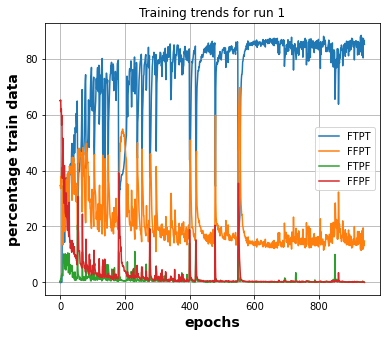

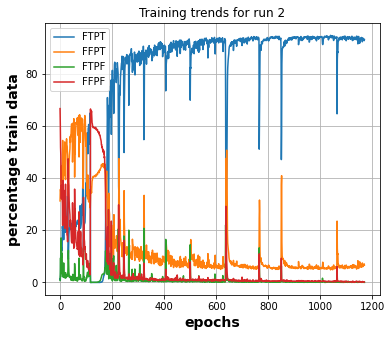

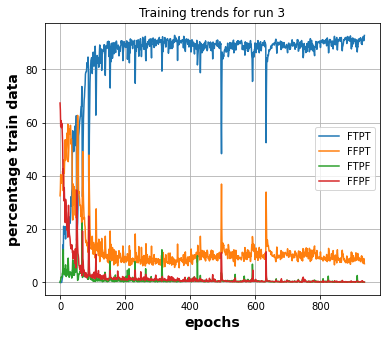

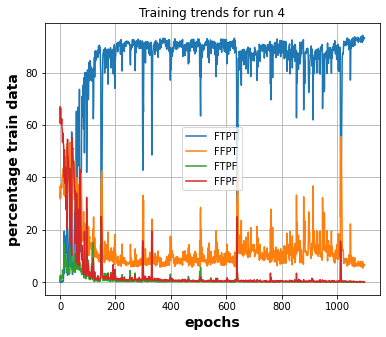

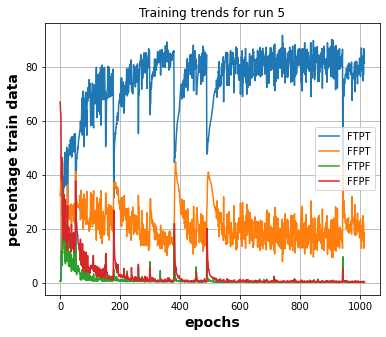

In [26]:
cnt=1
for epoch, analysis_data in full_analysis:
  analysis_data = np.array(analysis_data)
  # print("="*20+"run ",cnt,"="*20)
  
  plt.figure(figsize=(6,5))
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,0]/30,label="FTPT")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,1]/30,label="FFPT")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,2]/30,label="FTPF")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,3]/30,label="FFPF")

  plt.title("Training trends for run "+str(cnt))
  plt.grid()
  # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.legend()
  plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
  plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
  #plt.savefig(path + "run"+str(cnt)+".png",bbox_inches="tight")
  #plt.savefig(path + "run"+str(cnt)+".pdf",bbox_inches="tight")
  cnt+=1

In [27]:
#FTPT_analysis.to_csv(path+"synthetic_zeroth.csv",index=False)